# To do:

 - Both
     - Fix Injuries data
         - Find a better source for roster data
     - Use injury table to define return game
 - Mins
     - Figure out how to distribute mins for injury riddled games

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import duckdb
import warnings
import os

import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import randint, uniform

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib
import warnings
from datetime import datetime, timedelta

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

categories = ['PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK']
con = duckdb.connect(database=":memory:")

cwd = os.path.abspath(os.getcwd()).replace("\\", "/")
if cwd.startswith("C:/Users/Rodolfo/"):
    RUN_LOCATION = "local"
else:
    RUN_LOCATION = "cloud"
time_offset = {"local": 3, "cloud": -5}
now = str((datetime.now() + timedelta(hours=time_offset[RUN_LOCATION]) + timedelta(hours=-3)).date())
print(f"Today's date:", now)

tgt_stat = "PTS"
print('Target Stat:', tgt_stat)

Today's date: 2026-01-11
Target Stat: PTS


In [2]:
%run ./common_utils.ipynb

# ML Functions

In [3]:
def feature_importance(model, all_features):
    # Get gain importance
    importance = model.get_score(importance_type='gain')
    
    # Fill in 0 for missing features
    df_importance = pd.DataFrame({
        'feature': all_features,
        'importance': [importance.get(f, 0) for f in all_features]
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)
    
    df_importance['pct'] = df_importance.importance.cumsum() / df_importance.importance.sum()
    if df_importance.shape[0] >= 50:
        with pd.option_context('display.max_rows', None):
            display(df_importance)
    else:
        display(df_importance)
    
    xgb.plot_importance(model)
    plt.show()

In [4]:
def create_baseline_model(df, pred_col, DFS):
    
    train_df, val_df, test_df = DFS

    if pred_col == 'MP':
        print('Minutes Model')
        feature_cols = [
            'MP_L3_avg', 'MP_L5_avg', 'MP_L10_avg', 'game_spread_type'
        ]
    else:
        print(f'{pred_col} Stats Model')
        feature_cols = [
            'MP_L5_avg',
            'MP_L10_avg',
            f'{pred_col}_last_3_avg', f'{pred_col}_last_5_avg', f'{pred_col}_last_10_avg',
            f'Def_{pred_col}', f'Def_L5_{pred_col}'
        ]
    
    print('Train:', len(train_df), '/ Validation:', len(val_df), '/ Test:', len(test_df))
    
    X_train, y_train = train_df[feature_cols], train_df[pred_col]
    X_val,   y_val   = val_df[feature_cols],   val_df[pred_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[pred_col]

    # Convert to DMatrix (XGBoost internal format)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    params = {
        "objective": "reg:squarederror",
        "max_depth": 5,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42
    }

    # Train using native XGBoost API with early stopping
    evals = [(dtrain, "train"), (dval, "val")]
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Predict on test set
    preds = bst.predict(dtest)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)
    
    return bst

In [5]:
def hyperparam_tuning(DFS, pred_col, n_iter=20, early_stopping_rounds=50):
    """
    Hyperparameter tuning using native XGBoost API and DMatrix,
    with early stopping support (compatible with XGBoost 3.1.2)
    """

    train_df, val_df, test_df = DFS
    feature_cols = [col for col in train_df.columns if col not in ['Date', pred_col]]
    X_train, y_train = train_df[feature_cols], train_df[pred_col]
    X_val,   y_val   = val_df[feature_cols],   val_df[pred_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[pred_col]

    # Convert datasets to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    # Hyperparameter search space
    param_dist = {
        "n_estimators": randint(300, 1500),
        "learning_rate": uniform(0.01, 0.05),
        "max_depth": randint(3, 6),
        "min_child_weight": randint(1, 8),
        "subsample": uniform(0.7, 0.3),
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 2),
        "reg_lambda": uniform(0, 5),
        "reg_alpha": uniform(0, 2)
    }

    # Sample n_iter random parameter combinations
    param_list = []
    for _ in range(n_iter):
        sample = {k: (v.rvs() if hasattr(v, "rvs") else v) for k, v in param_dist.items()}
        sample['n_estimators'] = int(sample['n_estimators'])
        sample['max_depth'] = int(sample['max_depth'])
        sample['min_child_weight'] = int(sample['min_child_weight'])
        param_list.append(sample)

    best_mae = float('inf')
    best_params = None
    best_bst = None
        
    # Manual hyperparameter search
    for i, params in enumerate(param_list):
        print(f"\nTrial {i+1}/{n_iter}: {params}")
        num_boost_round = params.pop('n_estimators')
        params.update({
            "objective": "reg:squarederror",
            "tree_method": "hist",
            "device": "cuda",
            "seed": 42
        })
        evals = [(dtrain, 'train'), (dval, 'val')]
        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )
        # Predict on validation set to compute MAE
        val_preds = bst.predict(dval, iteration_range=(0, bst.best_iteration))
        mae = mean_absolute_error(y_val, val_preds)
        print(f"Validation MAE: {mae:.4f}")
        if mae < best_mae:
            best_mae = mae
            best_params = params.copy()
            best_bst = bst

    print("\nBest validation MAE:", best_mae)
    print("Best parameters:", best_params)

    # Predict on test set using best model
    preds = best_bst.predict(dtest, iteration_range=(0, best_bst.best_iteration))
    test_df[pred_col] = y_test
    test_df[f'{pred_col}_preds'] = preds
    test_df['Team'] = team_encoder.inverse_transform(test_df["Team"])
    test_df['Opp'] = team_encoder.inverse_transform(test_df["Opp"])
    test_df['Player'] = player_encoder.inverse_transform(test_df["Player"])
    test_df['Pos'] = position_encoder.inverse_transform(test_df["Pos"])
    analyze_df = test_df[['Date', 'Team', 'Player', 'Pos', 'Opp', pred_col, f'{pred_col}_preds']]
    print("\nTest Metrics:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
    print("MAE:", mean_absolute_error(y_test, preds))
    print("R²:", r2_score(y_test, preds))

    return best_bst, preds, y_test, analyze_df

### Create Base df

In [6]:
def load_df(file_name):
    df = pd.DataFrame()
    for i in [2021, 2022, 2023, 2024, 2025]:
        df_temp = pd.read_csv(f"../tables/{i}/{file_name}.csv")
        df_temp['Season'] = i
        df = pd.concat([df, df_temp])
        
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df.Date)
    if file_name == "season_gamelogs":
        df = df[~df[['Date', 'Team', 'Player']].duplicated(keep='last')]
    
    return df

In [7]:
# Load dfs
df = load_df('parlay_stats')
df2 = load_df('nba_schedule')
df3 = load_df('season_gamelogs')
df4 = load_df('injuries')
df5 = load_df('plyr_pos_xref')
df6 = load_df('daily_lineups')
gmlog_cols = ['game_id', 'Player', 'MP', 'PF']
df7 = load_df('h1_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_h1", "PF": "PF_h1"})
df8 = load_df('h2_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_h2", "PF": "PF_h2"})
df9 = load_df('q1_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_q1", "PF": "PF_q1"})
df10 = load_df('q2_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_q2", "PF": "PF_q2"})
df11 = load_df('q3_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_q3", "PF": "PF_q3"})
df12 = load_df('q4_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_q4", "PF": "PF_q4"})

df3 = df3.rename(columns={"3PM": "TPM", "3PA": "TPA", "3P%": "TP%", "TRB": "REB"}).drop(['Pos', 'Opp'], axis=1)
df3['PR'] = df3.PTS + df3.REB 
df3['PA'] = df3.PTS + df3.AST
df3['RA'] = df3.REB + df3.AST
df3['PRA'] = df3.PTS + df3.REB + df3.AST
df3['STL_BLK'] = df3.STL + df3.BLK
df = df.merge(df3, on=['Season', 'Date', 'Team', 'Player'], how='left')

df_mtch = df2[['Season', 'Date', 'AwayABV', 'HomeABV', 'AwayPTS', 'HomePTS', 'AwayB2B', 'HomeB2B', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch['Team_type'] = 'Away'
df_mtch = df_mtch.rename(columns={"AwayABV": "Team", "HomeABV": "Opp", "AwayB2B": "B2B"})[['Season', 'Date', 'Team', 'AwayPTS', 'HomePTS', 'Opp', 'B2B', 'is_OT', 'cup_gm', 'pstszn_gm', 'Team_type']]
df_mtch2 = df_mtch.copy().rename(columns={"Team": "Opp", "Opp": "Team", "HomeB2B": "B2B"})[['Season', 'Date', 'Team', 'AwayPTS', 'HomePTS', 'Opp', 'B2B', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch2['Team_type'] = 'Home'
df_mtch = pd.concat([df_mtch, df_mtch2])
df_mtch = df_mtch[['Season', 'Date', 'Team', 'Team_type', 'AwayPTS', 'HomePTS', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch = df_mtch.sort_values(["Team", "Date"])
df_mtch['team_game_num'] = df_mtch.groupby(["Team", "Season"]).cumcount() + 1
df_mtch['Spread'] = np.where(df_mtch.Team_type == 'Home', df_mtch.AwayPTS - df_mtch.HomePTS, df_mtch.HomePTS - df_mtch.AwayPTS)
df_mtch['Total'] = df_mtch.AwayPTS + df_mtch.HomePTS
df_mtch['is_Win'] = np.where(df_mtch.Spread > 0, 1, 0)
df_mtch['Szn_Wins'] = df_mtch.groupby(['Season', 'Team'])['is_Win'].cumsum()
df = df.drop(['Season', 'Team_type'], axis=1).merge(df_mtch, on=['Date', 'Team'])

df = df.merge(df4[['Date', 'Team', 'Player', 'Status']], on=['Date', 'Team', 'Player'], how='left')
df['Status'] = np.where((df.Active == 1) & (df.Status.isnull()), 'Available', df.Status)
df['Status'] = np.where((df.Active == 0), 'Out', df.Status)
df['Status'] = np.where((df.Status == 'Out') & (df.Active != 0), 'Available', df.Status)

df6['role'] = 1
df = df.merge(df6.drop('Pos', axis=1), on=['Season', 'Date', 'Team', 'Player'], how='left')
df['role'] = df.role.fillna(2).astype(int)

# Add gmlog splits
df_gmlog_comb = df7.merge(df8, on=['game_id', 'Player'])
for df_loop in (df9, df10, df11, df12):
    df_gmlog_comb = df_gmlog_comb.merge(df_loop, on=['game_id', 'Player'])
df = df.merge(df_gmlog_comb, on=['game_id', 'Player'], how='left')

team_encoder = LabelEncoder()
player_encoder = LabelEncoder()
team_type_encoder = LabelEncoder()
position_encoder = LabelEncoder()
status_encoder = LabelEncoder()

# Encode string cols
team_encoder.fit(pd.concat([df["Team"], df["Opp"]], axis=0))
players_fits = pd.concat([df["Player"], df3["Player"]], axis=0)
players_fits = pd.concat([players_fits, df4["Player"]], axis=0).drop_duplicates()
player_encoder.fit(players_fits)
df["Team"] = team_encoder.transform(df["Team"])
df["Opp"] = team_encoder.transform(df["Opp"])
df["Player_name"] = df.Player
df["Player"] = player_encoder.transform(df["Player"])
df["Pos"] = position_encoder.fit_transform(df["Pos"])
df['Team_type'] = team_type_encoder.fit_transform(df['Team_type'])
df["Status"] = status_encoder.fit_transform(df["Status"])
df_pred = df.copy()
df = df[(df.Active == 1) & (df.MP > 0)].sort_values(['Season', 'Date', 'Team', 'Player']).reset_index(drop=True)
print('base df created', datetime.now())

base df created 2026-01-11 12:08:03.497532


### Create missing_df

In [8]:
# Fill missing games from injuries.csv
team_games = df_pred[['Season', 'Team', 'Date']].drop_duplicates()
players = df_pred[['Season','Player','Team']].drop_duplicates()
fabricated = (players.sort_values('Season').groupby('Player', as_index=False).last())
fabricated['Season'] = fabricated['Season'] + 1
players = pd.concat([players, fabricated], ignore_index=True).drop_duplicates(['Season','Player','Team'])
expanded = team_games.merge(players, on=['Season', 'Team'], how='left')

df3["Team"] = team_encoder.transform(df3["Team"])
df3["Player"] = player_encoder.transform(df3["Player"])
df4["Team"] = team_encoder.transform(df4["Team"])
df4["Player"] = player_encoder.transform(df4["Player"])
df5['Team'] = team_encoder.transform(df5["Team"])
df5['Player'] = player_encoder.transform(df5["Player"])

expanded = expanded.merge(df3[['Season', 'Player', 'Date', 'MP']], on=['Season', 'Player', 'Date'], how='left').drop_duplicates(['Season', 'Date', 'Player', 'Team'])
expanded = expanded[(expanded.MP.isnull()) & (expanded.Date != now)].drop('MP', axis=1)
expanded = pd.concat([expanded, df4[df4.Status == 'Out'][['Season', 'Team', 'Date', 'Player']]])
df4 = df4.merge(expanded, on=['Season', 'Date', 'Team', 'Player'], how='right')

# Grab outs from players season gamelogs
df4 = df4.merge(df3, on=['Season', 'Date', 'Team', 'Player'], how='outer')
df4['Status'] = np.where(((df4.Active == 1) | (df4.MP > 0)), 'Available', df4.Status)
df4['Status'] = np.where(((df4.Active == 0) | (df4.MP == 0) | (df4.MP.isnull())), 'Out', df4.Status)
df4['Status'] = np.where((df4.Status == 'Out') & (df4.MP > 0), 'Available', df4.Status)
df4['Status'] = np.where((df4.Status != 'Out') & (df4.MP == 0), 'Out', df4.Status)
df4 = df4[df4.Status == 'Out'][['Season', 'Date', 'Team', 'Player']].drop_duplicates()

In [9]:
def create_df_missing(df, pred_col):
    df_missing = df[['Season', 'Date', 'Team', 'Player', 'role', pred_col]].copy()
    df_missing[f'{pred_col}_L10'] = (
        df_missing.groupby(['Player','Season'])[pred_col]
                  .transform(lambda x: x.rolling(10, min_periods=1).mean())
    )
    df_missing['role_L10_mode'] = (
        df_missing
            .groupby(['Player', 'Season'])['role']
            .transform(lambda x: x.rolling(10, min_periods=1)
                            .apply(lambda y: np.bincount(y.astype(np.int8), minlength=4).argmax(), raw=True))
    )
    df_missing = pd.merge_asof(df4, df_missing[["Season", "Player", "Date", "role", "role_L10_mode", f"{pred_col}_L10"]], 
                      on="Date", by=["Player", "Season"], direction="backward", allow_exact_matches=True).dropna()   
    df_missing = df_missing.merge(df5, on=['Season', 'Team', 'Player'])
    
    # Filter out old injuries
    df_missing = df_missing.sort_values(["Season", "Team", "Player", "Date"])
    df_missing["team_game_num"] = (df_missing.groupby(["Season", "Team"])["Date"].rank(method="dense").astype(int))
    df_missing["game_break"] = (df_missing.groupby(["Season", "Team", "Player"])["team_game_num"].diff().ne(1))
    df_missing["streak_id"] = (df_missing.groupby(["Season", "Team", "Player"])["game_break"].cumsum())
    df_missing["consecutive_games"] = (df_missing.groupby(["Season", "Team", "Player", "streak_id"]).cumcount().add(1))
    df_missing["eligible_today"] = (df_missing["consecutive_games"] < 10).astype(int)
    df_missing["role_for_count"] = np.where(df_missing["eligible_today"] == 1, df_missing["role_L10_mode"], np.nan)    

    df_missing["Player"] = player_encoder.inverse_transform(df_missing["Player"])
#     display(df_missing[df_missing.Team == 7].tail(50))

    out_minutes = (
    df_missing
      .groupby(["Season", "Date", "Team"])
      .agg(
#           team_mins_available=("MP_L10", lambda x: x.sum()),
          starters_out=("role_for_count", lambda x: (x == 1).sum())
      )
      .reset_index()
    )

    return out_minutes

# x = create_df_missing(df_pred, 'MP')
# display(x[(x.Team == 17)].tail(5))

# Minutes Projection Model

In [143]:
def setup_df_mins(con, df):

    df = df[['Season', 'Date', 'Team', 'Team_type', 'Opp', 'Player', 'Pos', 'role', 'B2B', 
             'MP', 'MP_h1', 'MP_h2', 'MP_q1', 'MP_q2', 'MP_q3', 'MP_q4', 
             'Spread', 'team_game_num', 'pstszn_gm', 'is_OT']]    
    df['dataset_gm'] = (df.groupby('Player')['MP'].cumcount().add(1).reset_index(drop=True))

    for col in ['MP']:
        for N in [3, 5, 10]:
            df[f'{col}_L{N}_avg'] = (
                df.groupby(['Player', 'Season'])[col]
                  .rolling(window=N, min_periods=1)
                  .mean()
                  .shift(1)
                  .reset_index(level=[0, 1], drop=True)
            )
            df[f'{col}_L{N}_avg'] = np.where(df['dataset_gm'] <= N, np.nan, df[f'{col}_L{N}_avg'])
            df[f'prev_team_mins_pct_L{N}'] = df[f'{col}_L{N}_avg'] / 240

    games_last_7_days = df.sort_values(['Player', 'Season', 'Date']).groupby(['Player', 'Season']).rolling('7D', on='Date', closed='left')['MP'].count().reset_index().rename(columns={"MP": "gms_L7_days"})
    games_last_7_days = games_last_7_days.drop_duplicates(
        subset=['Player', 'Season', 'Date']
    )
    df = df.merge(games_last_7_days, on=['Player', 'Season', 'Date'])
    df['gms_L7_days'] = df.gms_L7_days.fillna(0).astype(int)
        
    df['OT_adj_MP'] = np.where(df.is_OT != 0, df.MP - (5 * df.is_OT), df.MP)
    df['role'] = np.where(((df.OT_adj_MP >= 24) & (df.role != 1)), 1, df.role)
    df['role'] = np.where(((df.OT_adj_MP < 24) & (df.role == 1)), 2, df.role)
    df['role'] = np.where(((df.OT_adj_MP < 14) & (df.role == 2)), 3, df.role)
    for N in [1, 3, 5]:
        df[f"recent_role_L{N}"] = (
            df
            .groupby(["Player", "Season"])["role"]
            .rolling(5, min_periods=1)
            .apply(lambda arr: np.bincount(arr.astype(int), minlength=4).argmax(), raw=True)
            .reset_index(level=[0, 1], drop=True)
        )
        df[f"recent_role_L{N}"] = np.where(df['dataset_gm'] <= N, np.nan, df[f"recent_role_L{N}"])     
    
    df['game_spread_type'] = 0
    df['game_spread_type'] = np.where(abs(df.Spread) < 7, 1, df.game_spread_type) 
    df['game_spread_type'] = np.where((abs(df.Spread) >= 7) & (abs(df.Spread) <= 12), 2, df.game_spread_type) 
    df['game_spread_type'] = np.where(abs(df.Spread) > 12, 3, df.game_spread_type) 
    df['game_spread_type'] = np.where(df.is_OT > 0, 1, df.game_spread_type) 

    # Tell model games exist after players injuries/susp
    team_games = df[['Season', 'Team', 'Date', 'team_game_num']].drop_duplicates()
    players = df[['Season','Player','Team']].drop_duplicates()
    fabricated = (players.sort_values('Season').groupby('Player', as_index=False).last())
    fabricated['Season'] = fabricated['Season'] + 1
    players = pd.concat([players, fabricated], ignore_index=True).drop_duplicates(['Season','Player','Team'])
    expanded = team_games.merge(players, on=['Season', 'Team'], how='left')
    expanded = expanded.merge(df[['Season', 'Player', 'Date', 'MP']], on=['Season', 'Player', 'Date'], how='left').drop_duplicates(['Season', 'Date', 'Player', 'Team'])
    expanded['player_played'] = expanded['MP'].notna().astype(int)
    expanded['team_played_no_player'] = ((expanded['player_played'] == 0)).astype(int)
    expanded['tm_plays_after'] = (expanded.groupby(['Player'])['team_played_no_player'].shift(-1))
    expanded['missed_gms_aftr'] = 0
    expanded['missed_gms_aftr'] = np.where((expanded.player_played == 1) & (expanded.tm_plays_after == 1), 1, expanded.missed_gms_aftr)
    df = df.merge(expanded[['Date', 'Team', 'Player', 'missed_gms_aftr']], on=['Date', 'Team', 'Player'])
    
    df2 = create_df_missing(df, 'MP')
    df = df.merge(df2, on=["Season", "Date", "Team"], how='left')
    df['starters_out'] = df.starters_out.fillna(0)
    df['starters_out_L1'] = (
        df.groupby(['Player', 'Season'])['starters_out']
          .rolling(window=1, min_periods=1)
          .mean()
          .shift(1)
          .reset_index(level=[0, 1], drop=True)
    )
    df['starters_returning'] = np.where(df['starters_out_L1'] > df['starters_out'], df['starters_out_L1'] - df['starters_out'], 0)
    df['missed_games'] = (df.groupby(['Player', 'Team', 'Season'])['team_game_num'].diff().sub(1).fillna(0).astype(int))

    df['MP_Change'] = 0
    MP_Inc_conds = (
                    ((df.role != 3) & (df.starters_out > 2)) | 
                    ((df.role == 1) & (df.recent_role_L3 > 1)) | 
                    ((df.role == 1) & (df.recent_role_L5 > 1)) 
                   )
    df['MP_Change'] = np.where(MP_Inc_conds, 1, df['MP_Change'])
    MP_Dec_conds = (
                    ((df.role != 1) & (df.starters_returning > 2)) 
                   )
    df['MP_Change'] = np.where(MP_Dec_conds, -1, df['MP_Change'])
    
    df['MP_change_pct_L10'] = (df['MP'] - df['MP_L10_avg']) / df['MP_L10_avg']
    Injury_conds = (
        (
            ((df.role == 1) & (df['MP_change_pct_L10'] <= -0.25)) | 
            ((df.role == 2) & (df['MP_change_pct_L10'] <= -0.35)) | 
            ((df.role == 3) & (df['MP_change_pct_L10'] <= -0.45)) | 
            ((df.role == 1) & (df.MP_q4 == 0)
        ) & (df.missed_gms_aftr > 0) | (df.missed_games > 1))
    )
    df['Injured'] = (Injury_conds).astype(int)
    df['return_game'] = ((df.groupby('Player')['Injured'].shift(1) == 1) & (df.missed_games > 0)).astype(int)
    df['games_since_return'] = (df.groupby('Player')['return_game'].cumsum())
    df['games_since_return'] = (df.groupby(['Player', 'games_since_return']).cumcount())
    df['ramp_phase'] = 0
    df.loc[df.return_game == 1, 'ramp_phase'] = 1
    df.loc[(df.games_since_return.isin([1, 2, 3]) & (df.dataset_gm > 4)), 'ramp_phase'] = 2
    df.loc[df.games_since_return >= 4, 'ramp_phase'] = 0

    df = df.drop(['Season', 'Team_type', 'team_game_num', 'Spread', 'is_OT', 'starters_out_L1', 
                  'MP_h1', 'MP_h2', 'MP_q1', 'MP_q2', 'MP_q3', 'MP_q4', 'OT_adj_MP', 'MP_change_pct_L10',   
                  'missed_gms_aftr', 'Injured', 'return_game', 'games_since_return', 'dataset_gm'], axis=1)      
    return df

,Date,Team,Opp,Player,Pos,role,B2B,MP,pstszn_gm,MP_L3_avg,prev_team_mins_pct_L3,MP_L5_avg,prev_team_mins_pct_L5,MP_L10_avg,prev_team_mins_pct_L10,gms_L7_days,recent_role_L1,recent_role_L3,recent_role_L5,game_spread_type,starters_out,starters_returning,missed_games,MP_Change,ramp_phase
0,2021-10-19,2,16,81,0,2,0,22.98,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,3,0.0,1.0,0,0,0
1,2021-10-19,2,16,110,3,3,0,3.75,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,3,0.0,4.0,0,-1,0
2,2021-10-19,2,16,129,4,3,0,3.75,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,3,0.0,1.0,0,0,0
3,2021-10-19,2,16,244,3,3,0,3.75,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,3,0.0,0.0,0,0,0
4,2021-10-19,2,16,457,2,1,0,30.63,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,3,0.0,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123197,2026-01-10,28,4,630,2,2,0,23.35,0,37.400000,0.155833,37.416,0.155900,36.670,0.152792,4,1.0,1.0,1.0,3,3.0,0.0,0,1,0
123198,2026-01-10,28,4,648,3,2,0,21.43,0,24.406667,0.101694,20.434,0.085142,19.394,0.080808,1,1.0,1.0,1.0,3,3.0,0.0,0,1,2
123199,2026-01-10,28,4,649,0,1,0,24.70,0,13.973333,0.058222,17.802,0.074175,18.316,0.076317,4,2.0,2.0,2.0,3,3.0,0.0,0,1,0
123200,2026-01-10,28,4,944,1,1,0,28.85,0,12.286667,0.051194,13.164,0.054850,14.482,0.060342,4,3.0,3.0,3.0,3,3.0,0.0,0,1,0



Trial 1/10: {'n_estimators': 932, 'learning_rate': np.float64(0.022585880771131155), 'max_depth': 5, 'min_child_weight': 6, 'subsample': np.float64(0.9283204843194324), 'colsample_bytree': np.float64(0.8671992876331485), 'gamma': np.float64(1.879210947132869), 'reg_lambda': np.float64(2.554440964671758), 'reg_alpha': np.float64(0.15652710923412805)}
Validation MAE: 2.8778

Trial 2/10: {'n_estimators': 1355, 'learning_rate': np.float64(0.04798711736971747), 'max_depth': 4, 'min_child_weight': 5, 'subsample': np.float64(0.9303147583903206), 'colsample_bytree': np.float64(0.8605739806294342), 'gamma': np.float64(0.7735006770725035), 'reg_lambda': np.float64(3.4852000045360847), 'reg_alpha': np.float64(1.8411166329434796)}
Validation MAE: 2.8817

Trial 3/10: {'n_estimators': 944, 'learning_rate': np.float64(0.034460831721801324), 'max_depth': 5, 'min_child_weight': 6, 'subsample': np.float64(0.7535621860847123), 'colsample_bytree': np.float64(0.9179887297739224), 'gamma': np.float64(1.801

,feature,importance,pct
0,role,225883.281250,0.840327
1,recent_role_L1,30286.755859,0.952999
2,MP_Change,3217.958740,0.964971
3,game_spread_type,1785.489502,0.971613
4,MP_L10_avg,1280.840698,0.976378
5,MP_L5_avg,1050.342163,0.980286
6,MP_L3_avg,956.780884,0.983845
7,prev_team_mins_pct_L10,635.476624,0.986209
8,prev_team_mins_pct_L3,618.116638,0.988509
9,pstszn_gm,516.678589,0.990431


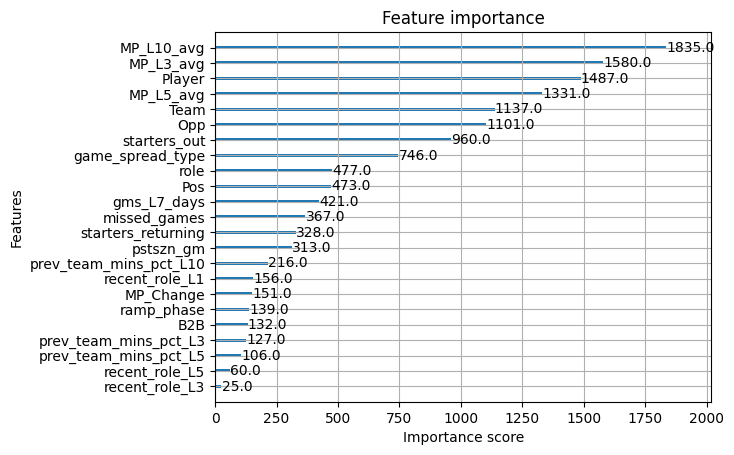

In [144]:
df_mins = df.copy()
df_mins = setup_df_mins(con, df_mins)
display(df_mins)

n = len(df_mins)
train_end = int(0.8 * n)
val_end   = int(0.9 * n)
mins_train_df = df_mins.iloc[:train_end]
mins_val_df   = df_mins.iloc[train_end:val_end]
mins_test_df  = df_mins.iloc[val_end:]
mins_DFS = (mins_train_df, mins_val_df, mins_test_df)

# mins_model = create_baseline_model(df_mins, "MP", mins_DFS)
mins_model, mins_preds, y_test_mins, analyze_df_mins = hyperparam_tuning(mins_DFS, "MP", n_iter=1)
# feature_importance(mins_model, df_mins.columns.tolist())

# mins_model.save_model("../ML_models/mins_model.json")
# print('Saved minutes model!')

,Date,Team,Opp,Player,Pos,role,B2B,pstszn_gm,MP_L3_avg,prev_team_mins_pct_L3,MP_L5_avg,prev_team_mins_pct_L5,MP_L10_avg,prev_team_mins_pct_L10,gms_L7_days,recent_role_L1,recent_role_L3,recent_role_L5,game_spread_type,starters_out,starters_returning,missed_games,MP_Change,ramp_phase,MP,MP_preds,Diff
1216,2025-10-23,IND,OKC,Bennedict Mathurin,SF,1,0,0,23.283333,0.097014,21.226000,0.088442,18.962000,0.079008,0,1.0,1.0,1.0,1,0.0,0.0,0,0,0,45.12,28.564692,16.555308
4604,2025-11-14,DAL,LAC,Naji Marshall,SF,1,0,0,27.433333,0.114306,26.654000,0.111058,24.859000,0.103579,4,1.0,1.0,1.0,1,2.0,0.0,0,0,0,47.15,31.628567,15.521433
6804,2025-11-30,ATL,PHI,Onyeka Okongwu,C,1,0,0,29.366667,0.122361,29.362000,0.122342,29.844000,0.124350,3,1.0,1.0,1.0,1,1.0,0.0,0,0,0,47.35,32.503117,14.846883
4592,2025-11-14,CHO,MIL,Moussa Diabate,C,1,0,0,24.480000,0.102000,22.712000,0.094633,21.137000,0.088071,3,2.0,2.0,2.0,1,1.0,1.0,0,1,0,43.28,28.896177,14.383823
4639,2025-11-14,LAC,DAL,James Harden,PG,1,0,0,36.380000,0.151583,35.614000,0.148392,34.420000,0.143417,3,1.0,1.0,1.0,1,1.0,0.0,0,0,0,51.05,36.677261,14.372739
1958,2025-10-27,PHO,UTA,Royce O'Neale,SF,1,0,0,28.463333,0.118597,28.463333,0.118597,28.463333,0.118597,3,1.0,1.0,1.0,1,1.0,0.0,0,0,0,46.08,31.953348,14.126652
914,2025-10-21,HOU,OKC,Alperen Sengun,C,1,0,0,35.966667,0.149861,36.730000,0.153042,34.656000,0.144400,0,1.0,1.0,1.0,1,0.0,0.0,0,0,0,48.88,34.824360,14.055640
6903,2025-11-30,PHI,ATL,Tyrese Maxey,PG,1,0,0,36.673333,0.152806,39.030000,0.162625,39.013000,0.162554,3,1.0,1.0,1.0,1,1.0,2.0,0,0,0,52.30,38.317783,13.982217
4638,2025-11-14,LAC,DAL,Ivica Zubac,C,1,0,0,32.270000,0.134458,29.916000,0.124650,30.003000,0.125012,3,1.0,1.0,1.0,1,1.0,0.0,0,0,0,46.18,33.068947,13.111053
935,2025-10-21,OKC,HOU,Cason Wallace,SG,1,0,0,19.156667,0.079819,20.084000,0.083683,22.409000,0.093371,0,1.0,1.0,1.0,1,0.0,0.0,0,0,0,41.65,28.559723,13.090277


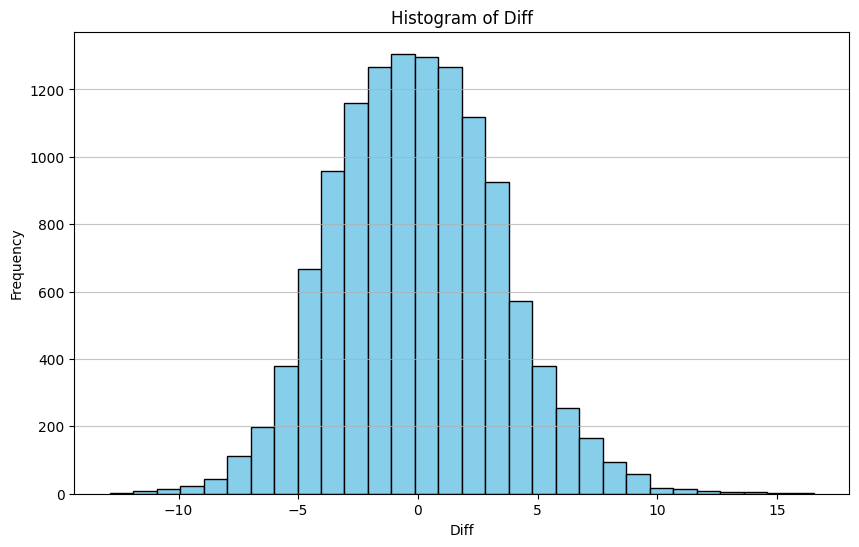

In [140]:
analyze_df_mins = mins_test_df.drop(['MP', 'MP_preds'], axis=1)\
                .merge(analyze_df_mins[['Date', 'Team', 'Player', 'MP', 'MP_preds']], on=['Date', 'Team', 'Player'])
analyze_df_mins['Diff'] = analyze_df_mins['MP'] - analyze_df_mins['MP_preds']
analyze_df_mins['Diff2'] = abs(analyze_df_mins['Diff'])
display(analyze_df_mins.sort_values('Diff', ascending=False).drop('Diff2', axis=1).head(10))
# display(analyze_df_mins[(analyze_df_mins.Early_Exit == 1) & (analyze_df_mins.MP_Decrease == 0)].sort_values('MP', ascending=True).head(10))

plt.figure(figsize=(10,6))
hist_col = 'Diff'
plt.hist(analyze_df_mins[hist_col], bins=30, color='skyblue', edgecolor='black')
plt.title(f'Histogram of {hist_col}')
plt.xlabel(hist_col)
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [25]:
rmse = np.sqrt(mean_squared_error(y_test_mins, mins_preds)) # splits[5] = y_test
inrange = 5
mae = mean_absolute_error(y_test_mins, mins_preds)
print('Target Range:', inrange)
print('Spread rules: \n< 7 == 1\n7-12 == 2\n12 >= 3')

df_yesterday = pd.read_csv(f'../tables/2025/gmday_preds_{tgt_stat}.csv')
df_yesterday['Date'] = pd.to_datetime(df_yesterday.Date)
df_yesterday = df_yesterday[(df_yesterday.Date == (datetime.strptime(now, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d"))]\
                .rename(columns={"MP": "MP_proj", "Spread": "Spread_Proj"})

df_gms = pd.read_csv(f"../tables/2025/season_gamelogs.csv")
df_gms['Date'] = pd.to_datetime(df_gms.Date)
df_gms = df_gms.merge(df_mtch, on=['Date', 'Team'])

df_yesterday = df_yesterday.merge(df_gms[['Date', 'Team', 'Player', 'MP', 'Spread']], on=['Date', 'Team', 'Player'])
df_yesterday['game_spread_type'] = 0
df_yesterday['game_spread_type'] = np.where(abs(df_yesterday.Spread) < 7, 1, df_yesterday.game_spread_type) 
df_yesterday['game_spread_type'] = np.where((abs(df_yesterday.Spread) >= 7) & (abs(df_yesterday.Spread) <= 12), 2, df_yesterday.game_spread_type) 
df_yesterday['game_spread_type'] = np.where(abs(df_yesterday.Spread) > 12, 3, df_yesterday.game_spread_type) 
df_yesterday['game_spread_type_proj'] = 0
df_yesterday['game_spread_type_proj'] = np.where(abs(df_yesterday.Spread_Proj) < 7, 1, df_yesterday.game_spread_type_proj) 
df_yesterday['game_spread_type_proj'] = np.where((abs(df_yesterday.Spread_Proj) >= 7) & (abs(df_yesterday.Spread_Proj) <= 12), 2, df_yesterday.game_spread_type_proj) 
df_yesterday['game_spread_type_proj'] = np.where(abs(df_yesterday.Spread_Proj) > 12, 3, df_yesterday.game_spread_type_proj) 
df_yesterday = df_yesterday[['Date', 'Team', 'Player', 'Pos', 'Opp', 'MP_proj', 'MP',  'game_spread_type', 'game_spread_type_proj']][df_yesterday.MP > 0]

df_yesterday['Diff'] = abs(df_yesterday['MP_proj'] - df_yesterday['MP'])
df_yesterday['InTgtRange'] = np.where(df_yesterday['Diff'] <= inrange, 1, 0)


print("\nYesterday's Results:")
print("Total Accuracy (InTgtRange):", ((df_yesterday.InTgtRange == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.InTgtRange == 1).sum(), '/', df_yesterday.shape[0])

df_yesterday = df_yesterday.drop(['Diff'], axis=1)

if df_yesterday.shape[0] >= 50:
    for tm in df_yesterday.Team.unique():
        display(df_yesterday[df_yesterday.Team == tm])
else:
    display(df_yesterday)

Target Range: 5
Spread rules: 
< 7 == 1
7-12 == 2
12 >= 3

Yesterday's Results:
Total Accuracy (InTgtRange): 0.6
45 / 75


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InTgtRange
0,2026-01-10,UTA,Kyle Filipowski,C,CHO,16.815247,24.70,3,0,0
2,2026-01-10,UTA,Brice Sensabaugh,SF,CHO,27.488867,29.90,3,0,1
3,2026-01-10,UTA,Keyonte George,PG,CHO,35.492023,23.35,3,0,0
35,2026-01-10,UTA,Isaiah Collier,PG,CHO,20.384226,34.45,3,0,0
38,2026-01-10,UTA,Taylor Hendricks,PF,CHO,22.883913,28.85,3,0,0
59,2026-01-10,UTA,Cody Williams,SG,CHO,22.800856,32.47,3,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InTgtRange
1,2026-01-10,DET,Paul Reed,C,LAC,23.444180,21.88,1,0,1
7,2026-01-10,DET,Jaden Ivey,SG,LAC,23.137087,20.33,1,0,1
29,2026-01-10,DET,Ausar Thompson,SF,LAC,25.248131,34.07,1,0,0
32,2026-01-10,DET,Duncan Robinson,SF,LAC,25.640120,28.12,1,0,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InTgtRange
4,2026-01-10,MIA,Bam Adebayo,C,IND,29.777124,24.80,3,0,1
10,2026-01-10,MIA,Jaime Jaquez Jr.,SF,IND,21.613693,25.48,3,0,1
39,2026-01-10,MIA,Andrew Wiggins,SF,IND,28.357567,19.95,3,0,0
42,2026-01-10,MIA,Kel'el Ware,C,IND,21.595373,17.13,3,0,1
46,2026-01-10,MIA,Norman Powell,SG,IND,29.579647,22.02,3,0,0
51,2026-01-10,MIA,Tyler Herro,SG,IND,24.983856,32.05,3,0,0
69,2026-01-10,MIA,Davion Mitchell,PG,IND,28.139174,19.25,3,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InTgtRange
5,2026-01-10,DAL,Daniel Gafford,C,CHI,23.171669,24.70,3,0,1
6,2026-01-10,DAL,Klay Thompson,SF,CHI,19.801037,19.88,3,0,1
12,2026-01-10,DAL,Cooper Flagg,SF,CHI,35.019722,28.22,3,0,0
13,2026-01-10,DAL,Naji Marshall,SF,CHI,29.067352,24.42,3,0,1
33,2026-01-10,DAL,Max Christie,SG,CHI,28.091322,27.08,3,0,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InTgtRange
8,2026-01-10,LAC,James Harden,PG,DET,34.445335,37.43,1,0,1
14,2026-01-10,LAC,Kawhi Leonard,SF,DET,35.371441,30.90,1,0,1
44,2026-01-10,LAC,Ivica Zubac,C,DET,25.228214,31.50,1,0,0
48,2026-01-10,LAC,Brook Lopez,C,DET,19.339445,12.18,1,0,0
62,2026-01-10,LAC,John Collins,PF,DET,27.408894,37.28,1,0,0
64,2026-01-10,LAC,Nicolas Batum,PF,DET,19.994682,14.40,1,0,0
66,2026-01-10,LAC,Kris Dunn,PG,DET,27.232679,38.42,1,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InTgtRange
9,2026-01-10,CLE,Evan Mobley,PF,MIN,30.231565,31.55,2,0,1
17,2026-01-10,CLE,Darius Garland,PG,MIN,30.172453,28.72,2,0,1
22,2026-01-10,CLE,Donovan Mitchell,SG,MIN,31.145683,31.42,2,0,1
25,2026-01-10,CLE,Sam Merrill,SG,MIN,25.494772,25.50,2,0,1
45,2026-01-10,CLE,Craig Porter Jr.,PG,MIN,17.095697,25.57,2,0,0
63,2026-01-10,CLE,De'Andre Hunter,SF,MIN,20.789375,21.10,2,0,1
65,2026-01-10,CLE,Jarrett Allen,C,MIN,26.446568,28.17,2,0,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InTgtRange
11,2026-01-10,IND,Pascal Siakam,PF,MIA,32.914082,26.37,3,0,0
24,2026-01-10,IND,Aaron Nesmith,SF,MIA,26.159426,27.22,3,0,1
27,2026-01-10,IND,Jay Huff,C,MIA,19.103306,18.87,3,0,1
36,2026-01-10,IND,Andrew Nembhard,PG,MIA,28.229261,29.02,3,0,1
43,2026-01-10,IND,Johnny Furphy,SG,MIA,23.207771,20.45,3,0,1
60,2026-01-10,IND,T.J. McConnell,PG,MIA,17.894365,16.65,3,0,1
75,2026-01-10,IND,Ben Sheppard,SG,MIA,19.491604,20.03,3,0,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InTgtRange
15,2026-01-10,MIN,Donte DiVincenzo,SG,CLE,28.545607,34.50,2,0,0
28,2026-01-10,MIN,Julius Randle,PF,CLE,31.105228,30.80,2,0,1
37,2026-01-10,MIN,Anthony Edwards,SG,CLE,33.802944,35.13,2,0,1
49,2026-01-10,MIN,Jaden McDaniels,PF,CLE,27.964291,26.67,2,0,1
56,2026-01-10,MIN,Naz Reid,C,CLE,20.737074,28.13,2,0,0
68,2026-01-10,MIN,Rudy Gobert,C,CLE,31.809103,31.40,2,0,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InTgtRange
16,2026-01-10,CHI,Coby White,SG,DAL,25.773817,28.93,3,0,1
21,2026-01-10,CHI,Jalen Smith,C,DAL,18.002966,16.30,3,0,1
30,2026-01-10,CHI,Nikola Vucevic,C,DAL,30.186722,28.92,3,0,1
50,2026-01-10,CHI,Tre Jones,PG,DAL,25.450806,27.98,3,0,1
58,2026-01-10,CHI,Matas Buzelis,PF,DAL,27.136488,25.23,3,0,1
70,2026-01-10,CHI,Isaac Okoro,SG,DAL,24.855799,28.75,3,0,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InTgtRange
18,2026-01-10,SAS,De'Aaron Fox,PG,BOS,31.155107,36.37,1,0,0
19,2026-01-10,SAS,Stephon Castle,PG,BOS,29.967863,26.60,1,0,1
26,2026-01-10,SAS,Luke Kornet,C,BOS,25.386185,24.37,1,0,1
31,2026-01-10,SAS,Dylan Harper,SG,BOS,18.774458,22.40,1,0,1
40,2026-01-10,SAS,Harrison Barnes,PF,BOS,26.040985,26.32,1,0,1
47,2026-01-10,SAS,Keldon Johnson,SF,BOS,20.417931,28.23,1,0,0
61,2026-01-10,SAS,Julian Champagnie,SF,BOS,27.403421,34.88,1,0,0
67,2026-01-10,SAS,Victor Wembanyama,C,BOS,20.375517,26.42,1,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InTgtRange
20,2026-01-10,BOS,Jaylen Brown,SF,SAS,30.368717,43.37,1,0,0
54,2026-01-10,BOS,Payton Pritchard,PG,SAS,33.319981,28.52,1,0,1
55,2026-01-10,BOS,Derrick White,SG,SAS,34.675499,42.08,1,0,0
71,2026-01-10,BOS,Luka Garza,C,SAS,19.359676,25.13,1,0,0
72,2026-01-10,BOS,Neemias Queta,C,SAS,25.244364,23.80,1,0,1
73,2026-01-10,BOS,Anfernee Simons,SG,SAS,20.470400,25.47,1,0,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InTgtRange
23,2026-01-10,CHO,Miles Bridges,PF,UTA,29.701498,21.77,3,0,0
34,2026-01-10,CHO,Kon Knueppel,SF,UTA,28.716938,18.12,3,0,0
52,2026-01-10,CHO,Collin Sexton,SG,UTA,18.149403,17.67,3,0,1
53,2026-01-10,CHO,Brandon Miller,SF,UTA,29.633955,21.97,3,0,0
57,2026-01-10,CHO,LaMelo Ball,PG,UTA,26.274910,22.60,3,0,1
74,2026-01-10,CHO,Ryan Kalkbrenner,C,UTA,20.381092,23.50,3,0,1


# Main Model

In [145]:
def setup_df_main(df, tgt_stat):
    
    df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'role', 'MP', 'team_game_num', 
             'PTS', 'FG', 'FGA', 'FG%', 'TPA', 'TPM', 'TP%', 'FT', 'FTA', 'FT%', 
             'MP_h1', 'MP_h2', 'MP_q1', 'MP_q2', 'MP_q3', 'MP_q4', 
             f'Off_{tgt_stat}', f'Off_L3_{tgt_stat}', f'Off_L5_{tgt_stat}', f'Off_L10_{tgt_stat}', f'Off_{tgt_stat}_Rk',
             f'Def_{tgt_stat}', f'Def_L3_{tgt_stat}', f'Def_L5_{tgt_stat}', f'Def_L10_{tgt_stat}', f'Def_{tgt_stat}_Rk',
             'Spread', 'Total', 'is_OT']]
    df['dataset_gm'] = (df.groupby('Player')['MP'].cumcount().add(1).reset_index(drop=True))
    
    # Create rolling + lag features    
    for col in ['MP', 'FG', 'FGA', 'FT', 'FTA', 'TPM', 'TPA']:
        for N in [3, 5, 10]:
            df[f'{col}_L{N}_avg'] = (
                df.groupby(['Player', 'Season'])[col]
                  .rolling(window=N, min_periods=1)
                  .mean()
                  .shift(1)
                  .reset_index(level=[0, 1], drop=True)
            )
            
    for N in [1, 3, 5]:
        df[f"recent_role_L{N}"] = (
            df
            .groupby(["Player", "Season"])["role"]
            .rolling(5, min_periods=1)
            .apply(lambda arr: np.bincount(arr.astype(int), minlength=4).argmax(), raw=True)
            .reset_index(level=[0, 1], drop=True)
        )

    df['OT_adj_MP'] = np.where(df.is_OT != 0, df.MP - (5 * df.is_OT), df.MP)
    df['role'] = np.where(((df.OT_adj_MP >= 24) & (df.role != 1)), 1, df.role)
    df['role'] = np.where(((df.OT_adj_MP < 24) & (df.role == 1)), 2, df.role)
    df['role'] = np.where(((df.OT_adj_MP < 14) & (df.role == 2)), 3, df.role)
    for N in [1, 3, 5]:
        df[f"recent_role_L{N}"] = (
            df
            .groupby(["Player", "Season"])["role"]
            .rolling(5, min_periods=1)
            .apply(lambda arr: np.bincount(arr.astype(int), minlength=4).argmax(), raw=True)
            .reset_index(level=[0, 1], drop=True)
        )
    
    df['game_spread_type'] = 0
    df['game_spread_type'] = np.where(abs(df.Spread) < 7, 1, df.game_spread_type) 
    df['game_spread_type'] = np.where((abs(df.Spread) >= 7) & (abs(df.Spread) <= 12), 2, df.game_spread_type) 
    df['game_spread_type'] = np.where(abs(df.Spread) > 12, 3, df.game_spread_type) 
    df['game_spread_type'] = np.where(df.is_OT > 0, 1, df.game_spread_type) 
    
    df['TeamPTS'] = (df.Total + (df.Spread * -1)) / 2
    df['TeamPTS_type'] = 0
    df['TeamPTS_type'] = np.where((df.TeamPTS > 104) & (df.TeamPTS <= 116), 1, df.TeamPTS_type)
    df['TeamPTS_type'] = np.where((df.TeamPTS > 116) & (df.TeamPTS <= 126), 2, df.TeamPTS_type)
    df['TeamPTS_type'] = np.where((df.TeamPTS > 126), 3, df.TeamPTS_type)
    
    # Tell model games exist after players injuries/susp
    team_games = df[['Season', 'Team', 'Date', 'team_game_num']].drop_duplicates()
    players = df[['Season','Player','Team']].drop_duplicates()
    fabricated = (players.sort_values('Season').groupby('Player', as_index=False).last())
    fabricated['Season'] = fabricated['Season'] + 1
    players = pd.concat([players, fabricated], ignore_index=True).drop_duplicates(['Season','Player','Team'])
    expanded = team_games.merge(players, on=['Season', 'Team'], how='left')
    expanded = expanded.merge(df[['Season', 'Player', 'Date', 'MP']], on=['Season', 'Player', 'Date'], how='left').drop_duplicates(['Season', 'Date', 'Player', 'Team'])
    expanded['player_played'] = expanded['MP'].notna().astype(int)
    expanded['team_played_no_player'] = ((expanded['player_played'] == 0)).astype(int)
    expanded['tm_plays_after'] = (expanded.groupby(['Player'])['team_played_no_player'].shift(-1))
    expanded['missed_gms_aftr'] = 0
    expanded['missed_gms_aftr'] = np.where((expanded.player_played == 1) & (expanded.tm_plays_after == 1), 1, expanded.missed_gms_aftr)
    df = df.merge(expanded[['Date', 'Team', 'Player', 'missed_gms_aftr']], on=['Date', 'Team', 'Player'])
    
    df2 = create_df_missing(df, 'MP')
    df = df.merge(df2, on=["Season", "Date", "Team"], how='left')
    df['starters_out'] = df.starters_out.fillna(0)
    df['starters_out_L1'] = (
        df.groupby(['Player', 'Season'])['starters_out']
          .rolling(window=1, min_periods=1)
          .mean()
          .shift(1)
          .reset_index(level=[0, 1], drop=True)
    )
    df['starters_returning'] = np.where(df['starters_out_L1'] > df['starters_out'], df['starters_out_L1'] - df['starters_out'], 0)
    df['missed_games'] = (df.groupby(['Player', 'Team', 'Season'])['team_game_num'].diff().sub(1).fillna(0).astype(int))

    df['MP_Change'] = 0
    MP_Inc_conds = (
                    ((df.role != 3) & (df.starters_out > 2)) | 
                    ((df.role == 1) & (df.recent_role_L3 > 1)) | 
                    ((df.role == 1) & (df.recent_role_L5 > 1)) 
                   )
    df['MP_Change'] = np.where(MP_Inc_conds, 1, df['MP_Change'])
    MP_Dec_conds = (
                    ((df.role != 1) & (df.starters_returning > 2)) 
                   )
    df['MP_Change'] = np.where(MP_Dec_conds, -1, df['MP_Change'])
    
    df['MP_change_pct_L10'] = (df['MP'] - df['MP_L10_avg']) / df['MP_L10_avg']
    Injury_conds = (
        (
            ((df.role == 1) & (df['MP_change_pct_L10'] <= -0.25)) | 
            ((df.role == 2) & (df['MP_change_pct_L10'] <= -0.35)) | 
            ((df.role == 3) & (df['MP_change_pct_L10'] <= -0.45)) | 
            ((df.role == 1) & (df.MP_q4 == 0)
        ) & (df.missed_gms_aftr > 0) | (df.missed_games > 1))
    )
    df['Injured'] = (Injury_conds).astype(int)
    df['return_game'] = ((df.groupby('Player')['Injured'].shift(1) == 1) & (df.missed_games > 0)).astype(int)
    df['games_since_return'] = (df.groupby('Player')['return_game'].cumsum())
    df['games_since_return'] = (df.groupby(['Player', 'games_since_return']).cumcount())
    df['ramp_phase'] = 0
    df.loc[df.return_game == 1, 'ramp_phase'] = 1
    df.loc[(df.games_since_return.isin([1, 2, 3]) & (df.dataset_gm > 4)), 'ramp_phase'] = 2
    df.loc[df.games_since_return >= 4, 'ramp_phase'] = 0
    
    df = df.drop(['Season', 'team_game_num', 'is_OT', 'Spread', 'Total', 'TeamPTS', 
                 'FG', 'FGA', 'FG%', 'TPA', 'TPM', 'TP%', 'FT', 'FTA', 'FT%', 
                 'MP_h1', 'MP_h2', 'MP_q1', 'MP_q2', 'MP_q3', 'MP_q4', 
                 'OT_adj_MP', 'MP_change_pct_L10', 'starters_out_L1', 
                 'missed_gms_aftr', 'Injured', 'return_game', 'games_since_return', 'dataset_gm'], axis=1)
        
    return df

In [147]:
df_main = df.copy()
df_main = setup_df_main(df_main, tgt_stat)
display(df_main)

n = len(df_main)
train_end = int(0.65 * n)
val_end   = int(0.85 * n)
main_train_df = df_main.iloc[:train_end]
main_val_df   = df_main.iloc[train_end:val_end]
main_test_df  = df_main.iloc[val_end:]
main_DFS = (main_train_df, main_val_df, main_test_df)

# stat_model = create_baseline_model(df_main, tgt_stat, main_DFS)
stat_model, stat_preds, y_test_stat, analyze_df_stat = hyperparam_tuning(main_DFS, tgt_stat, n_iter=1)
# feature_importance(stat_model, df_main.columns.tolist())

# stat_model.save_model(f"../ML_models/{tgt_stat}_model.json")
# print(f'Saved {tgt_stat} model!')

,Date,Team,Opp,Player,Pos,role,MP,PTS,Off_PTS,Off_L3_PTS,Off_L5_PTS,Off_L10_PTS,Off_PTS_Rk,Def_PTS,Def_L3_PTS,Def_L5_PTS,Def_L10_PTS,Def_PTS_Rk,MP_L3_avg,MP_L5_avg,MP_L10_avg,FG_L3_avg,FG_L5_avg,FG_L10_avg,FGA_L3_avg,FGA_L5_avg,FGA_L10_avg,FT_L3_avg,FT_L5_avg,FT_L10_avg,FTA_L3_avg,FTA_L5_avg,FTA_L10_avg,TPM_L3_avg,TPM_L5_avg,TPM_L10_avg,TPA_L3_avg,TPA_L5_avg,TPA_L10_avg,recent_role_L1,recent_role_L3,recent_role_L5,game_spread_type,TeamPTS_type,starters_out,starters_returning,missed_games,MP_Change,ramp_phase
0,2021-10-19,2,16,81,0,2,22.98,6.0,6.000000,6.000000,6.0,6.0,7.0,18.000000,18.000000,18.0,18.0,3.0,2.226667,3.750,5.966000,0.333333,0.6,0.400000,0.666667,0.8,0.600000,0.000000,0.2,0.100000,0.000000,0.4,0.200000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2.0,2.0,2.0,3,0,0.0,1.0,0,0,0
1,2021-10-19,2,16,110,3,3,3.75,0.0,0.000000,0.000000,0.0,0.0,7.0,9.000000,9.000000,9.0,9.0,2.0,7.330000,7.330,7.330000,0.000000,0.0,0.000000,1.000000,1.0,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,1.0,1.000000,3.0,3.0,3.0,3,0,0.0,4.0,0,-1,0
2,2021-10-19,2,16,129,4,3,3.75,2.0,2.000000,2.000000,2.0,2.0,6.0,21.000000,21.000000,21.0,21.0,3.0,29.133333,27.612,27.590000,5.000000,3.6,3.600000,11.333333,9.4,8.600000,1.333333,1.4,2.100000,1.666667,1.6,2.300000,2.666667,1.8,1.800000,6.000000,5.0,4.800000,3.0,3.0,3.0,3,0,0.0,1.0,0,0,0
3,2021-10-19,2,16,244,3,3,3.75,0.0,0.000000,0.000000,0.0,0.0,7.0,9.000000,9.000000,9.0,9.0,2.0,11.650000,11.650,11.650000,2.000000,2.0,2.000000,2.500000,2.5,2.500000,0.500000,0.5,0.500000,1.000000,1.0,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,3.0,3.0,3.0,3,0,0.0,0.0,0,0,0
4,2021-10-19,2,16,457,2,1,30.63,20.0,20.000000,20.000000,20.0,20.0,2.0,20.000000,20.000000,20.0,20.0,3.0,4.620000,8.382,7.942857,0.666667,1.8,1.571429,2.000000,3.4,3.428571,0.000000,0.8,0.571429,0.333333,1.0,0.714286,0.000000,0.4,0.428571,0.666667,1.2,1.142857,1.0,1.0,1.0,3,0,0.0,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123197,2026-01-10,28,4,630,2,2,23.35,4.0,24.138889,19.666667,23.6,24.8,9.0,25.081081,23.000000,23.6,26.6,21.0,37.400000,37.416,36.670000,7.333333,8.4,8.200000,15.333333,17.6,17.600000,3.666667,4.0,5.400000,4.000000,4.6,6.100000,1.333333,2.8,3.000000,5.000000,7.2,7.500000,1.0,1.0,1.0,3,0,3.0,0.0,0,1,0
123198,2026-01-10,28,4,648,3,2,21.43,7.0,7.636364,8.000000,7.8,7.6,53.0,25.800000,16.333333,15.4,22.6,13.0,24.406667,20.434,19.394000,3.000000,2.8,3.000000,6.333333,5.6,5.800000,2.000000,2.2,1.500000,2.333333,2.6,1.900000,0.000000,0.0,0.100000,0.000000,0.0,0.100000,1.0,1.0,1.0,3,0,3.0,0.0,0,1,2
123199,2026-01-10,28,4,649,0,1,24.70,4.0,9.250000,7.666667,6.8,8.2,37.0,17.416667,7.666667,10.4,14.7,10.0,13.973333,17.802,18.316000,3.000000,2.8,3.100000,6.333333,7.0,7.100000,1.000000,0.8,1.300000,1.666667,1.4,2.100000,0.666667,0.4,0.700000,1.666667,2.0,2.300000,2.0,2.0,2.0,3,0,3.0,0.0,0,1,0
123200,2026-01-10,28,4,944,1,1,28.85,7.0,5.346154,5.000000,4.2,5.2,54.0,24.600000,22.000000,30.2,25.8,28.0,12.286667,13.164,14.482000,2.000000,1.6,1.900000,4.333333,3.0,3.700000,0.000000,0.2,0.600000,0.000000,0.4,0.700000,1.000000,0.8,0.800000,2.333333,1.6,2.100000,3.0,3.0,3.0,3,0,3.0,0.0,0,1,0



Trial 1/10: {'n_estimators': 972, 'learning_rate': np.float64(0.028340390478484995), 'max_depth': 3, 'min_child_weight': 1, 'subsample': np.float64(0.8773840544294959), 'colsample_bytree': np.float64(0.8274906125400281), 'gamma': np.float64(0.6273939157540382), 'reg_lambda': np.float64(1.8987297224837234), 'reg_alpha': np.float64(1.0233425348337601)}
Validation MAE: 2.4542

Trial 2/10: {'n_estimators': 1208, 'learning_rate': np.float64(0.02417226566573155), 'max_depth': 3, 'min_child_weight': 1, 'subsample': np.float64(0.956599877788952), 'colsample_bytree': np.float64(0.8029027600031418), 'gamma': np.float64(0.17129047446693013), 'reg_lambda': np.float64(1.2321385845083177), 'reg_alpha': np.float64(1.0326519859168357)}
Validation MAE: 2.4469

Trial 3/10: {'n_estimators': 790, 'learning_rate': np.float64(0.050972676543235555), 'max_depth': 3, 'min_child_weight': 4, 'subsample': np.float64(0.807194710053592), 'colsample_bytree': np.float64(0.8859313265661176), 'gamma': np.float64(1.043

,Date,Team,Opp,Player,Pos,role,MP,Off_PTS,Off_L3_PTS,Off_L5_PTS,Off_L10_PTS,Off_PTS_Rk,Def_PTS,Def_L3_PTS,Def_L5_PTS,Def_L10_PTS,Def_PTS_Rk,is_OT,MP_L3_avg,MP_L5_avg,MP_L10_avg,FG_L3_avg,FG_L5_avg,FG_L10_avg,FGA_L3_avg,FGA_L5_avg,FGA_L10_avg,FT_L3_avg,FT_L5_avg,FT_L10_avg,FTA_L3_avg,FTA_L5_avg,FTA_L10_avg,TPM_L3_avg,TPM_L5_avg,TPM_L10_avg,TPA_L3_avg,TPA_L5_avg,TPA_L10_avg,recent_role_L1,recent_role_L3,recent_role_L5,game_spread_type,TeamPTS_type,starters_out,starters_returning,missed_games,MP_Increase,ramp_phase,PTS,PTS_preds,Diff
14094,2025-12-07,LAL,PHI,Austin Reaves,SG,1,39.13,28.400000,30.333333,28.000000,28.200000,2.0,28.619048,18.666667,23.80,22.200000,22.0,0,35.830000,37.688000,37.192000,9.333333,9.8,9.2,17.000000,16.200000,15.800000,9.666667,9.6,8.6,11.000000,10.8,9.7,3.666667,4.200000,3.200000,8.666667,8.200000,7.200000,1.0,1.0,1.0,1,1,1.0,2.0,0,0,0,11.0,28.292854,-17.292854
17591,2026-01-05,BOS,CHI,Jaylen Brown,SF,1,34.57,30.093750,34.000000,33.800000,32.400000,1.0,29.100000,26.000000,33.00,29.800000,28.0,0,34.500000,34.524000,34.870000,12.666667,13.0,11.7,23.333333,22.600000,21.700000,6.000000,5.4,6.8,7.666667,7.0,8.6,2.666667,2.400000,2.200000,7.333333,6.000000,5.300000,1.0,1.0,1.0,3,1,0.0,0.0,0,0,0,14.0,31.087177,-17.087177
18391,2026-01-10,DAL,CHI,Cooper Flagg,SF,1,28.22,26.000000,26.000000,26.000000,26.000000,5.0,28.937500,29.333333,25.20,27.600000,26.0,0,35.813333,35.912000,36.100000,7.000000,6.4,7.9,15.000000,16.000000,16.200000,3.000000,2.6,3.3,3.333333,2.8,4.1,1.666667,1.200000,1.500000,4.333333,4.200000,3.700000,1.0,1.0,1.0,3,1,3.0,0.0,0,1,0,11.0,26.467810,-15.467810
1531,2025-03-23,HOU,DEN,Fred VanVleet,PG,1,41.72,14.490566,21.000000,17.800000,12.600000,24.0,21.298507,31.000000,24.40,21.600000,9.0,0,36.750000,34.036000,32.109000,6.000000,5.8,4.1,12.666667,13.200000,10.800000,3.333333,2.4,1.5,4.000000,3.2,1.9,4.333333,4.000000,2.700000,8.333333,8.600000,7.500000,1.0,1.0,1.0,1,1,0.0,0.0,0,0,0,7.0,22.352552,-15.352552
11071,2025-11-16,GSW,NOP,Stephen Curry,PG,1,28.12,27.416667,34.666667,28.600000,26.400000,6.0,22.846154,16.666667,18.80,22.800000,14.0,0,29.853333,30.442000,30.668000,11.000000,10.0,9.6,21.333333,22.000000,20.200000,8.333333,6.8,5.8,9.000000,7.4,6.2,5.000000,4.800000,4.700000,12.666667,13.200000,11.900000,1.0,1.0,1.0,3,2,1.0,0.0,0,0,0,9.0,24.229691,-15.229691
17276,2026-01-03,ATL,TOR,Onyeka Okongwu,C,1,30.30,16.571429,22.000000,21.800000,18.100000,12.0,17.548387,13.666667,15.00,17.900000,11.0,0,30.576667,32.578000,34.189000,7.666667,7.6,6.6,15.000000,15.400000,14.200000,4.000000,3.8,2.6,5.000000,4.8,3.2,2.666667,2.800000,2.300000,5.666667,6.400000,5.800000,1.0,1.0,1.0,3,2,2.0,0.0,0,0,0,4.0,18.917473,-14.917473
2138,2025-03-27,DAL,ORL,Naji Marshall,SF,1,41.07,13.344262,22.000000,21.000000,21.900000,25.0,17.451613,18.000000,17.60,17.100000,1.0,0,33.883333,35.260000,36.463000,11.333333,10.0,9.6,17.333333,17.400000,17.800000,2.333333,3.0,3.8,3.666667,4.8,5.0,1.333333,1.000000,1.200000,3.000000,3.400000,4.300000,1.0,1.0,1.0,2,0,3.0,1.0,0,1,0,6.0,20.881111,-14.881111
1130,2025-03-20,SAC,CHI,Zach LaVine,SG,1,32.85,23.976190,23.333333,26.400000,26.000000,3.0,22.290909,15.666667,13.60,17.100000,25.0,0,35.156667,37.108000,36.927000,6.333333,7.2,8.2,10.000000,12.400000,14.600000,3.000000,3.8,2.7,3.666667,4.2,3.1,3.666667,2.800000,3.400000,6.000000,5.800000,6.500000,1.0,1.0,1.0,2,1,2.0,0.0,1,0,0,8.0,22.639994,-14.639994
7996,2025-10-27,DEN,MIN,Aaron Gordon,PF,1,32.82,25.333333,25.333333,25.333333,25.333333,5.0,29.250000,26.000000,29.25,29.250000,23.0,0,31.925000,31.925000,31.925000,11.000000,11.0,11.0,16.000000,16.000000,16.000000,6.000000,6.0,6.0,6.000000,6.0,6.0,5.500000,5.500000,5.500000,8.500000,8.500000,8.500000,1.0,1.0,1.0,3,3,0.0,0.0,0,0,0,9.0,23.213417,-14.213417
3799,2025-04-06,GSW,HOU,Stephen Curry,PG,1,32.67,24.439394,25.333333,28.200000,24.000000,10.0,25.013889,20.333333,20.80,24.100000,30.0,0,34.323333,32.534000,32.271000,13.000000,10.0,8.0,25.333333,21.400000,17.900000,8.000000,6.2,5.4,8.33333

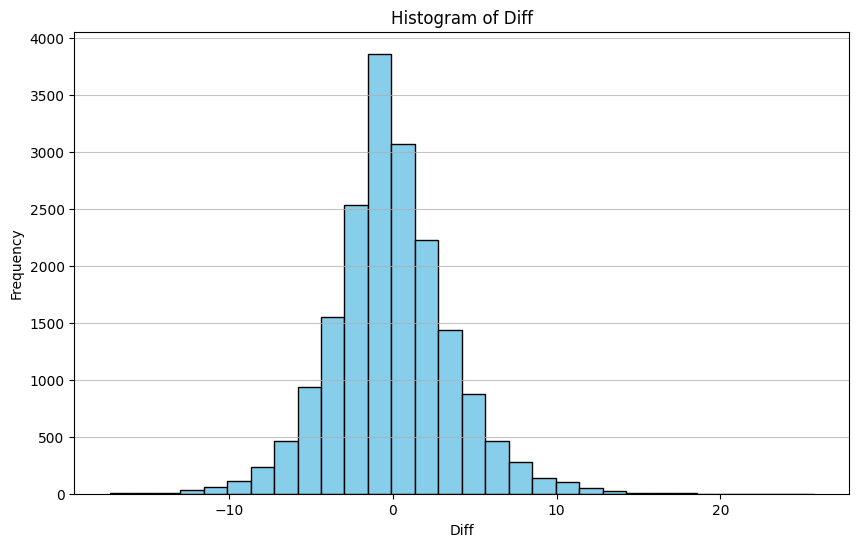

In [115]:
analyze_df_stat = main_test_df.drop([tgt_stat, f'{tgt_stat}_preds'], axis=1)\
                .merge(analyze_df_stat[['Date', 'Team', 'Player', tgt_stat, f'{tgt_stat}_preds']], on=['Date', 'Team', 'Player'])
analyze_df_stat['Diff'] = analyze_df_stat[tgt_stat] - analyze_df_stat[f'{tgt_stat}_preds']
analyze_df_stat['Diff2'] = abs(analyze_df_stat['Diff'])
display(analyze_df_stat.sort_values('Diff', ascending=True).drop('Diff2', axis=1).head(15))
# display(analyze_df_stat[(analyze_df_stat.Date == '2026-01-04') & (analyze_df_stat.Team == 'LAL')])

plt.figure(figsize=(10,6))
hist_col = 'Diff'
plt.hist(analyze_df_stat[hist_col], bins=30, color='skyblue', edgecolor='black')
plt.title(f'Histogram of {hist_col}')
plt.xlabel(hist_col)
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [27]:
rmse = np.sqrt(mean_squared_error(y_test_stat, stat_preds)) # splits[5] = y_test
inrange = 3
mae = mean_absolute_error(y_test_stat, stat_preds)
print('Target Range:', inrange)

df_yesterday = pd.read_csv(f'../tables/2025/gmday_preds_{tgt_stat}.csv')
df_yesterday['Date'] = pd.to_datetime(df_yesterday.Date)
df_yesterday = df_yesterday[(df_yesterday.Date == (datetime.strptime(now, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d"))]\
                .rename(columns={"MP": "MP_proj"})

df_gms = pd.read_csv(f"../tables/2025/season_gamelogs.csv")
df_gms['Date'] = pd.to_datetime(df_gms.Date)
df_gms = df_gms.rename(columns={"TRB": "REB", "3PM": "TPM", "3PA": "TPA"})
df_gms['STL_BLK'] = df_gms.STL + df_gms.BLK
df_gms['PR'] = df_gms.PTS + df_gms.REB 
df_gms['PA'] = df_gms.PTS + df_gms.AST
df_gms['RA'] = df_gms.REB + df_gms.AST
df_gms['PRA'] = df_gms.PTS + df_gms.REB + df_gms.AST

df_yesterday = df_yesterday.merge(df_gms[['Date', 'Team', 'Player', tgt_stat, 'MP']], on=['Date', 'Team', 'Player'])
df_yesterday = df_yesterday[['Date', 'Team', 'Player', 'Pos', 'Opp', 'MP_proj', 'MP', f'{tgt_stat}_line', f'{tgt_stat}_proj', tgt_stat]][df_yesterday.MP > 0]

df_yesterday['Diff'] = df_yesterday[f'{tgt_stat}_proj'] - df_yesterday[f'{tgt_stat}_line']
df_yesterday['Diff2'] = abs(df_yesterday[f'{tgt_stat}_proj'] - df_yesterday[tgt_stat])
df_yesterday['Act_Res'] = np.where(df_yesterday[tgt_stat] > df_yesterday[f'{tgt_stat}_line'], 'O', 'U')
df_yesterday['Pred_Res'] = np.where(df_yesterday[f'{tgt_stat}_proj'] > df_yesterday[f'{tgt_stat}_line'], 'O', 'U')
df_yesterday['ParlayHit'] = np.where(df_yesterday['Act_Res'] == df_yesterday['Pred_Res'], 1, 0)
df_yesterday['InRMSE_Range'] = np.where(df_yesterday['Diff2'] <= inrange, 1, 0)
# df_yesterday = df_yesterday[(abs(df_yesterday.Diff) > rmse)]
# df_yesterday = df_yesterday[df_yesterday.InRMSE_Range == 0]

print("Total Accuracy (ParlayHit):", ((df_yesterday.ParlayHit == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.ParlayHit == 1).sum(), "/", df_yesterday.shape[0])

print("\nTotal Accuracy (InRMSE_Range):", ((df_yesterday.InRMSE_Range == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.InRMSE_Range == 1).sum(), "/", df_yesterday.shape[0])

df_yesterday = df_yesterday.drop(['Diff', 'Diff2', 'Act_Res', 'Pred_Res'], axis=1).sort_values(f'{tgt_stat}_line', ascending=False)

if df_yesterday.shape[0] >= 50:
    for tm in df_yesterday.Team.unique():
        display(df_yesterday[(df_yesterday.Team == tm)]) #  & (df_yesterday.ParlayHit == 1)
else:
    display(df_yesterday)

Target Range: 3
Total Accuracy (ParlayHit): 0.5866666666666667
44 / 75

Total Accuracy (InRMSE_Range): 0.44
33 / 75


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
37,2026-01-10,MIN,Anthony Edwards,SG,CLE,33.802944,35.13,29.5,27.678833,25,1,1
28,2026-01-10,MIN,Julius Randle,PF,CLE,31.105228,30.80,21.5,19.094440,20,1,1
15,2026-01-10,MIN,Donte DiVincenzo,SG,CLE,28.545607,34.50,13.5,10.248269,15,0,0
56,2026-01-10,MIN,Naz Reid,C,CLE,20.737074,28.13,13.5,12.817665,25,0,0
49,2026-01-10,MIN,Jaden McDaniels,PF,CLE,27.964291,26.67,13.5,12.455074,12,1,1
68,2026-01-10,MIN,Rudy Gobert,C,CLE,31.809103,31.40,10.5,10.300590,8,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
22,2026-01-10,CLE,Donovan Mitchell,SG,MIN,31.145683,31.42,28.5,25.691763,28,1,1
17,2026-01-10,CLE,Darius Garland,PG,MIN,30.172453,28.72,18.5,15.447085,22,0,0
9,2026-01-10,CLE,Evan Mobley,PF,MIN,30.231565,31.55,17.5,13.621857,24,0,0
65,2026-01-10,CLE,Jarrett Allen,C,MIN,26.446568,28.17,12.5,12.789488,16,1,0
25,2026-01-10,CLE,Sam Merrill,SG,MIN,25.494772,25.50,11.5,14.093375,20,1,0
63,2026-01-10,CLE,De'Andre Hunter,SF,MIN,20.789375,21.10,11.5,11.808626,4,0,0
45,2026-01-10,CLE,Craig Porter Jr.,PG,MIN,17.095697,25.57,5.5,4.152344,0,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
20,2026-01-10,BOS,Jaylen Brown,SF,SAS,30.368717,43.37,28.5,25.599453,27,1,1
55,2026-01-10,BOS,Derrick White,SG,SAS,34.675499,42.08,17.5,16.747580,29,0,0
54,2026-01-10,BOS,Payton Pritchard,PG,SAS,33.319981,28.52,16.5,17.306122,4,0,0
73,2026-01-10,BOS,Anfernee Simons,SG,SAS,20.470400,25.47,13.5,13.623545,5,0,0
72,2026-01-10,BOS,Neemias Queta,C,SAS,25.244364,23.80,9.5,9.359100,9,1,1
71,2026-01-10,BOS,Luka Garza,C,SAS,19.359676,25.13,8.5,8.642857,11,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
3,2026-01-10,UTA,Keyonte George,PG,CHO,35.492023,23.35,27.5,22.229954,4,1,0
2,2026-01-10,UTA,Brice Sensabaugh,SF,CHO,27.488867,29.90,16.5,11.153957,26,0,0
0,2026-01-10,UTA,Kyle Filipowski,C,CHO,16.815247,24.70,13.5,7.358861,4,1,0
35,2026-01-10,UTA,Isaiah Collier,PG,CHO,20.384226,34.45,9.5,7.615599,17,0,0
38,2026-01-10,UTA,Taylor Hendricks,PF,CHO,22.883913,28.85,6.5,4.715446,7,0,1
59,2026-01-10,UTA,Cody Williams,SG,CHO,22.800856,32.47,6.5,5.985065,15,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
11,2026-01-10,IND,Pascal Siakam,PF,MIA,32.914082,26.37,26.5,22.820107,11,1,0
36,2026-01-10,IND,Andrew Nembhard,PG,MIA,28.229261,29.02,17.5,15.620658,29,0,0
24,2026-01-10,IND,Aaron Nesmith,SF,MIA,26.159426,27.22,16.5,13.770043,12,1,1
60,2026-01-10,IND,T.J. McConnell,PG,MIA,17.894365,16.65,10.5,9.995538,12,0,1
27,2026-01-10,IND,Jay Huff,C,MIA,19.103306,18.87,9.5,7.093176,8,1,1
43,2026-01-10,IND,Johnny Furphy,SG,MIA,23.207771,20.45,6.5,5.119099,10,0,0
75,2026-01-10,IND,Ben Sheppard,SG,MIA,19.491604,20.03,6.5,6.401786,3,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
14,2026-01-10,LAC,Kawhi Leonard,SF,DET,35.371441,30.90,25.5,28.874361,26,1,1
8,2026-01-10,LAC,James Harden,PG,DET,34.445335,37.43,24.5,20.291874,19,1,1
62,2026-01-10,LAC,John Collins,PF,DET,27.408894,37.28,13.5,13.140068,25,0,0
44,2026-01-10,LAC,Ivica Zubac,C,DET,25.228214,31.50,12.5,11.126442,17,0,0
66,2026-01-10,LAC,Kris Dunn,PG,DET,27.232679,38.42,7.5,7.726862,2,0,0
48,2026-01-10,LAC,Brook Lopez,C,DET,19.339445,12.18,5.5,6.588215,0,0,0
64,2026-01-10,LAC,Nicolas Batum,PF,DET,19.994682,14.40,5.5,5.205322,0,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
12,2026-01-10,DAL,Cooper Flagg,SF,CHI,35.019722,28.22,23.5,27.166862,11,0,0
13,2026-01-10,DAL,Naji Marshall,SF,CHI,29.067352,24.42,16.5,12.974503,14,1,1
33,2026-01-10,DAL,Max Christie,SG,CHI,28.091322,27.08,15.5,13.356470,10,1,0
6,2026-01-10,DAL,Klay Thompson,SF,CHI,19.801037,19.88,14.5,9.755993,10,1,1
5,2026-01-10,DAL,Daniel Gafford,C,CHI,23.171669,24.70,11.5,6.627703,6,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
46,2026-01-10,MIA,Norman Powell,SG,IND,29.579647,22.02,21.5,22.824118,6,0,0
51,2026-01-10,MIA,Tyler Herro,SG,IND,24.983856,32.05,21.5,20.491182,21,1,1
4,2026-01-10,MIA,Bam Adebayo,C,IND,29.777124,24.80,16.5,11.387651,13,1,1
39,2026-01-10,MIA,Andrew Wiggins,SF,IND,28.357567,19.95,14.5,12.795768,11,1,1
10,2026-01-10,MIA,Jaime Jaquez Jr.,SF,IND,21.613693,25.48,11.5,15.357152,16,1,1
42,2026-01-10,MIA,Kel'el Ware,C,IND,21.595373,17.13,10.5,11.889072,2,0,0
69,2026-01-10,MIA,Davion Mitchell,PG,IND,28.139174,19.25,7.5,7.303606,1,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
67,2026-01-10,SAS,Victor Wembanyama,C,BOS,20.375517,26.42,20.5,20.273281,21,0,1
18,2026-01-10,SAS,De'Aaron Fox,PG,BOS,31.155107,36.37,19.5,16.519264,21,0,0
19,2026-01-10,SAS,Stephon Castle,PG,BOS,29.967863,26.60,17.5,14.598108,9,1,0
47,2026-01-10,SAS,Keldon Johnson,SF,BOS,20.417931,28.23,12.5,13.763814,18,1,0
61,2026-01-10,SAS,Julian Champagnie,SF,BOS,27.403421,34.88,11.5,11.980896,12,1,1
40,2026-01-10,SAS,Harrison Barnes,PF,BOS,26.040985,26.32,9.5,8.000045,6,1,1
31,2026-01-10,SAS,Dylan Harper,SG,BOS,18.774458,22.40,8.5,6.266292,5,1,1
26,2026-01-10,SAS,Luke Kornet,C,BOS,25.386185,24.37,6.5,9.066336,5,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
57,2026-01-10,CHO,LaMelo Ball,PG,UTA,26.274910,22.60,19.5,18.916355,17,1,1
34,2026-01-10,CHO,Kon Knueppel,SF,UTA,28.716938,18.12,19.5,17.557613,12,1,0
53,2026-01-10,CHO,Brandon Miller,SF,UTA,29.633955,21.97,19.5,18.662865,18,1,1
23,2026-01-10,CHO,Miles Bridges,PF,UTA,29.701498,21.77,18.5,15.721078,15,1,1
52,2026-01-10,CHO,Collin Sexton,SG,UTA,18.149403,17.67,13.5,12.517505,15,0,1
74,2026-01-10,CHO,Ryan Kalkbrenner,C,UTA,20.381092,23.50,6.5,6.393651,12,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
30,2026-01-10,CHI,Nikola Vucevic,C,DAL,30.186722,28.92,18.5,16.169285,15,1,1
58,2026-01-10,CHI,Matas Buzelis,PF,DAL,27.136488,25.23,17.5,16.950203,15,1,1
16,2026-01-10,CHI,Coby White,SG,DAL,25.773817,28.93,16.5,13.252863,22,0,0
21,2026-01-10,CHI,Jalen Smith,C,DAL,18.002966,16.30,10.5,7.667989,7,1,1
50,2026-01-10,CHI,Tre Jones,PG,DAL,25.450806,27.98,10.5,9.474769,13,0,0
70,2026-01-10,CHI,Isaac Okoro,SG,DAL,24.855799,28.75,7.5,7.313025,13,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
7,2026-01-10,DET,Jaden Ivey,SG,LAC,23.137087,20.33,12.5,7.934702,8,1,1
29,2026-01-10,DET,Ausar Thompson,SF,LAC,25.248131,34.07,12.5,10.145050,6,1,0
32,2026-01-10,DET,Duncan Robinson,SF,LAC,25.640120,28.12,11.5,9.318120,20,0,0
1,2026-01-10,DET,Paul Reed,C,LAC,23.444180,21.88,10.5,4.699653,8,1,0


### Today's predictions

In [19]:
df_lines = pd.read_csv(f"../tables/2025/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
df_lines = df_lines[~(df_lines.Team.isnull())]

# Predict Mins
df_lines["Team"] = team_encoder.transform(df_lines["Team"])
df_pred = df_pred.merge(df_lines[['Date', 'Team', 'Spread', 'Total']], on=['Date', 'Team'], how='left')
df_pred = df_pred[~df_pred[['Date', 'Team', 'Player']].duplicated(keep='last')]
df_pred['Spread_x'] = np.where(df_pred.Spread_x.isnull(), df_pred.Spread_y, df_pred.Spread_x)
df_pred['Total_x'] = np.where(df_pred.Total_x.isnull(), df_pred.Total_y, df_pred.Total_x)
df_pred = df_pred.rename(columns={"Spread_x": "Spread", "Total_x": "Total"}).drop(['Spread_y', 'Total_y'], axis=1)
df_pred_mins = setup_df_mins(con, df_pred)
df_pred_mins = df_pred_mins.drop(['Date', 'MP'], axis=1)
DM_mins = xgb.DMatrix(df_pred_mins)
df_pred['MP'] = mins_model.predict(DM_mins)

# Predict Stat
df_pred = setup_df_main(df_pred, tgt_stat)
feature_cols = [col for col in df_pred.columns if col not in ['Date', tgt_stat]]
df_pred = df_pred[df_pred.Date == now][feature_cols]
DM_stats = xgb.DMatrix(df_pred)
df_pred[f"{tgt_stat}_proj"] = stat_model.predict(DM_stats)

df_pred['Team'] = team_encoder.inverse_transform(df_pred["Team"])
df_lines['Team'] = team_encoder.inverse_transform(df_lines["Team"])
df_pred['Opp'] = team_encoder.inverse_transform(df_pred["Opp"])
df_pred['Player'] = player_encoder.inverse_transform(df_pred["Player"])
df_pred['Pos'] = position_encoder.inverse_transform(df_pred["Pos"])

df_lines = df_lines[df_lines.Date == now][['Team', 'Player', f'{tgt_stat}_line']]
df_pred = df_pred.merge(df_lines, on=['Team', 'Player'])

tds_picks = df_pred[~(df_pred[f'{tgt_stat}_line'].isnull())]\
            [['Team', 'Player', 'Pos', 'Opp', 'MP', 'MP_L5_avg', f'{tgt_stat}_line', f'{tgt_stat}_proj']]
tds_picks['Diff'] = abs((df_pred[f'{tgt_stat}_line'] - df_pred[f'{tgt_stat}_proj']))
tds_picks['Diff2'] = abs((df_pred['MP'] - df_pred['MP_L5_avg']))
tds_picks = tds_picks.sort_values('Diff', ascending=False).drop(['Diff', 'Diff2'], axis=1)
if tds_picks.shape[0] >= 50:
    print(tds_picks.shape[0], 'rows')
    for tm in tds_picks.Team.unique():
        display(tds_picks[tds_picks.Team == tm])
else:
    display(tds_picks)

79 rows


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
3,DAL,Cooper Flagg,SF,CHI,34.877983,35.060416,23.5,32.352329
40,DAL,Klay Thompson,SF,CHI,19.711555,21.632449,14.5,9.236803
38,DAL,Naji Marshall,SF,CHI,29.004318,29.721384,16.5,12.556532
71,DAL,Daniel Gafford,C,CHI,22.891153,21.607458,11.5,7.705599
28,DAL,Max Christie,SG,CHI,28.048771,32.197705,15.5,15.218596


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
9,LAC,James Harden,PG,DET,34.585907,31.617859,24.5,19.060875
16,LAC,Kris Dunn,PG,DET,27.324738,29.148875,7.5,9.484239
34,LAC,Kawhi Leonard,SF,DET,35.355709,35.822804,25.5,24.097054
56,LAC,John Collins,PF,DET,27.310980,28.087081,13.5,12.122191
60,LAC,Nicolas Batum,PF,DET,19.865387,22.048779,5.5,4.436164
80,LAC,Brook Lopez,C,DET,19.358852,17.263658,5.5,4.709839
68,LAC,Ivica Zubac,C,DET,25.439487,26.275244,12.5,11.711125


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
77,UTA,Kyle Filipowski,C,CHO,22.263597,18.819390,13.5,8.695690
48,UTA,Brice Sensabaugh,SF,CHO,27.488518,30.391598,16.5,12.357641
1,UTA,Keyonte George,PG,CHO,35.560730,36.948724,27.5,23.917027
14,UTA,Isaiah Collier,PG,CHO,20.342699,23.707318,9.5,7.016881
0,UTA,Jusuf Nurkic,C,CHO,21.938583,29.053764,14.5,13.564387
33,UTA,Cody Williams,SG,CHO,15.369821,16.718267,6.5,6.161374
58,UTA,Taylor Hendricks,PF,CHO,21.731537,13.309198,6.5,6.557586


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
35,BOS,Jaylen Brown,SF,SAS,30.184689,35.615982,28.5,23.798794
6,BOS,Payton Pritchard,PG,SAS,33.207363,33.463226,16.5,19.240051
70,BOS,Neemias Queta,C,SAS,25.353771,24.682459,9.5,10.584725
24,BOS,Anfernee Simons,SG,SAS,20.604074,27.442722,13.5,12.479936
59,BOS,Sam Hauser,PF,SAS,24.367800,24.273373,8.5,9.237844
78,BOS,Luka Garza,C,SAS,19.469666,20.991129,8.5,8.286345
19,BOS,Derrick White,SG,SAS,34.737598,36.399760,17.5,17.578276


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
27,DET,Jaden Ivey,SG,LAC,17.657253,18.714117,12.5,7.986569
79,DET,Paul Reed,C,LAC,21.745913,19.149487,10.5,6.755045
43,DET,Ausar Thompson,SF,LAC,25.512501,23.344654,12.5,9.767867
7,DET,Cade Cunningham,PG,LAC,28.961437,29.753079,27.5,29.647007
72,DET,Isaiah Stewart,C,LAC,26.312607,27.531289,13.5,11.488750
41,DET,Duncan Robinson,SF,LAC,25.951101,24.589728,11.5,9.636445


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
47,SAS,Julian Champagnie,SF,BOS,27.371269,28.929845,11.5,15.990936
62,SAS,Victor Wembanyama,C,BOS,25.055107,23.436224,20.5,24.930460
8,SAS,De'Aaron Fox,PG,BOS,31.238485,33.256572,19.5,15.609566
10,SAS,Stephon Castle,PG,BOS,29.899569,31.295600,17.5,14.552330
73,SAS,Luke Kornet,C,BOS,20.862520,26.126344,6.5,9.228551
45,SAS,Keldon Johnson,SF,BOS,20.443951,26.883014,12.5,10.283139
29,SAS,Dylan Harper,SG,BOS,18.815567,20.834475,8.5,7.297438
57,SAS,Harrison Barnes,PF,BOS,26.340679,25.199904,9.5,9.312605


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
5,IND,Andrew Nembhard,PG,MIA,28.077969,28.035640,17.5,21.564129
39,IND,Aaron Nesmith,SF,MIA,26.326366,30.366482,16.5,13.457699
11,IND,T.J. McConnell,PG,MIA,17.704943,19.494502,10.5,8.863965
74,IND,Jay Huff,C,MIA,23.592142,20.361196,9.5,10.598925
31,IND,Ben Sheppard,SG,MIA,19.440357,22.988223,6.5,5.653405
32,IND,Johnny Furphy,SG,MIA,22.933090,17.677945,6.5,5.777812
51,IND,Pascal Siakam,PF,MIA,33.053574,35.111358,26.5,26.689190


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
63,MIA,Bam Adebayo,C,IND,29.766186,28.137746,16.5,12.496722
20,MIA,Norman Powell,SG,IND,29.579735,29.819009,21.5,24.517599
12,MIA,Davion Mitchell,PG,IND,28.092182,30.106031,7.5,10.086540
42,MIA,Jaime Jaquez Jr.,SF,IND,21.395817,25.288812,11.5,14.044351
44,MIA,Andrew Wiggins,SF,IND,28.411907,28.575127,14.5,12.133932
22,MIA,Tyler Herro,SG,IND,24.973227,21.186340,21.5,19.650036
65,MIA,Kel'el Ware,C,IND,21.494087,27.148786,10.5,10.005382


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
54,CLE,Evan Mobley,PF,MIN,30.133820,32.641370,17.5,13.550961
26,CLE,Sam Merrill,SG,MIN,25.738743,22.874684,11.5,13.267471
4,CLE,Darius Garland,PG,MIN,30.083729,32.045939,18.5,17.270479
46,CLE,De'Andre Hunter,SF,MIN,20.593554,25.538966,11.5,10.526191
15,CLE,Craig Porter Jr.,PG,MIN,16.959568,21.704658,5.5,4.795888
21,CLE,Donovan Mitchell,SG,MIN,31.176603,34.440084,28.5,29.042130
64,CLE,Jarrett Allen,C,MIN,26.793076,30.073451,12.5,12.881584


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
2,CHO,LaMelo Ball,PG,UTA,26.395157,26.343233,19.5,15.797670
75,CHO,Ryan Kalkbrenner,C,UTA,25.695995,25.823212,6.5,9.025587
36,CHO,Brandon Miller,SF,UTA,29.610872,31.164067,19.5,21.597351
50,CHO,Miles Bridges,PF,UTA,29.666979,33.795005,18.5,17.385324
37,CHO,Kon Knueppel,SF,UTA,28.680298,29.868917,19.5,18.442122
18,CHO,Collin Sexton,SG,UTA,18.199537,21.501746,13.5,12.663968


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
25,MIN,Donte DiVincenzo,SG,CLE,28.492519,29.434958,13.5,9.819305
69,MIN,Rudy Gobert,C,CLE,31.779594,30.946760,10.5,13.891539
17,MIN,Anthony Edwards,SG,CLE,33.880749,35.080136,29.5,27.330666
66,MIN,Naz Reid,C,CLE,20.701506,23.515725,13.5,11.388565
55,MIN,Jaden McDaniels,PF,CLE,27.922119,29.257576,13.5,14.704912
53,MIN,Julius Randle,PF,CLE,30.886240,32.671330,21.5,20.963623


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
23,CHI,Coby White,SG,DAL,25.459122,21.464116,16.5,12.921269
67,CHI,Jalen Smith,C,DAL,17.931976,24.094700,10.5,8.069004
52,CHI,Matas Buzelis,PF,DAL,27.081228,30.119911,17.5,18.553555
13,CHI,Tre Jones,PG,DAL,25.932039,27.218114,10.5,11.126436
30,CHI,Isaac Okoro,SG,DAL,24.997698,27.844672,7.5,6.963158
61,CHI,Nikola Vucevic,C,DAL,30.168858,32.842683,18.5,18.681303
